<h1>Procesamiento de datos a gran escala</h1>

<p><strong>Objetivo: </strong> El objetivo de este cuaderno es aplicar el algoritmo de clustering a un conjunto de datos sencillos. </p>

**Autores:**
- Julián Camilo Ramos Granada
- María Fernanda Rodríguez Ospina

<h2>Clustering</h2>

<h2>Indice</h2>

<div class="alert alert-block alert-info" style="margin-top: 20px">
<ul>
  <li>Cargar los Datos</li>
  <li>Aplicando Algortimo K-Medias</li>
</ul>

Tiempo estimado: <strong>10 min</strong>

</div>
<hr>

<h3>Cargar los datos</h3>

Para este ejercicio se estará utilizando el conjunto de datos Iris, la cual es una fuente en línea en formato CSV (valores separados por coma).
<p> Este set de datos posee diferentes medidas sobre la planta Iris y es famosamente utilizado como ejemplo en analítica de datos:
  </p>
Se utiliza este conjunto para ejemplificar la creación de clusters:

<ul>
  <li>descripción: <a href="https://archive.ics.uci.edu/ml/datasets/Iris" target="_blank">https://archive.ics.uci.edu/ml/datasets/Iris</a></li>
  <li>fuente de datos: <a href="https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data" target="_blank">https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data</a></li>
    <li>tipo de datos: csv</li>

Se va a utilizar la librería Pandas de Python para realizar la lectura de archivos. Se cargan los datos, se agregan cabeceras y se muestra el resultado:

In [1]:
import sys
!{sys.executable} -m pip install wget

Defaulting to user installation because normal site-packages is not writeable


Lo que se hará a continuación es crear un entorno de trabajo en PySpark para analizar el conjunto de datos Iris, uno de los más conocidos en aprendizaje automático.
Primero, se descargará el archivo CSV que contiene la información de las flores Iris directamente desde el repositorio público de la Universidad de California (UCI Machine Learning Repository).
Luego, se establecerá una sesión de Spark para permitir el procesamiento distribuido de los datos, y se definirá un esquema estructurado que especifica el tipo de cada columna (longitud y ancho del sépalo y pétalo, y la especie correspondiente).
Finalmente, se leerán los datos en un DataFrame de Spark y se mostrará una vista preliminar de los primeros registros para verificar su correcta carga.

In [2]:
import wget
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, FloatType, StringType

# Crear la sesión de Spark
spark = SparkSession.builder \
    .appName("IrisAnalysis") \
    .getOrCreate()

# Leer datos desde archivo CSV
url_path = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
local_path = "iris.data"

wget.download(url_path, local_path)

schema = StructType([StructField("sepal_length", FloatType(), True),
                     StructField("sepal_width",  FloatType(), True),
                     StructField("petal_length", FloatType(), True),
                     StructField("petal_width",  FloatType(), True),
                     StructField("Species",        StringType(), True)])

df00 = spark.read.format("csv").option("header", "false").schema(schema).load(local_path)

df00.show(5)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/05 18:53:39 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/11/05 18:53:40 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/11/05 18:53:40 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
25/11/05 18:53:40 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
25/11/05 18:53:40 WARN Utils: Service 'SparkUI' could not bind on port 4043. Attempting port 4044.


-1 / unknown

+------------+-----------+------------+-----------+-----------+
|sepal_length|sepal_width|petal_length|petal_width|    Species|
+------------+-----------+------------+-----------+-----------+
|         5.1|        3.5|         1.4|        0.2|Iris-setosa|
|         4.9|        3.0|         1.4|        0.2|Iris-setosa|
|         4.7|        3.2|         1.3|        0.2|Iris-setosa|
|         4.6|        3.1|         1.5|        0.2|Iris-setosa|
|         5.0|        3.6|         1.4|        0.2|Iris-setosa|
+------------+-----------+------------+-----------+-----------+
only showing top 5 rows



Se imprime la estructura del DataFrame que contiene los datos del conjunto Iris

In [3]:
df00.printSchema()

root
 |-- sepal_length: float (nullable = true)
 |-- sepal_width: float (nullable = true)
 |-- petal_length: float (nullable = true)
 |-- petal_width: float (nullable = true)
 |-- Species: string (nullable = true)



Se va a verificar si existen valores nulos.
Haciendo uso de: count, when, isnan y col, que permiten recorrer cada columna del DataFrame y contar cuántos registros contienen valores faltantes (NaN o NULL).
Se va a mostrar en una tabla donde cada columna indica el número de valores nulos detectados en esa variable.

In [4]:
from pyspark.sql.functions import count, when, isnan, col
df00.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df00.columns]).show()

+------------+-----------+------------+-----------+-------+
|sepal_length|sepal_width|petal_length|petal_width|Species|
+------------+-----------+------------+-----------+-------+
|           0|          0|           0|          0|      0|
+------------+-----------+------------+-----------+-------+




### Aplicar Indexador a Columna "Species"

Se va a convertir la columna categórica “Species” en valores numéricos para que pueda ser utilizada en modelos de aprendizaje.

In [5]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
# StringIndexer Initialization
indexer = StringIndexer(inputCol="Species", outputCol="Species_Indexed")
indexerModel = indexer.fit(df00)

# Transform the DataFrame using the fitted StringIndexer model
indexed_df = indexerModel.transform(df00)
indexed_df.show()

+------------+-----------+------------+-----------+-----------+---------------+
|sepal_length|sepal_width|petal_length|petal_width|    Species|Species_Indexed|
+------------+-----------+------------+-----------+-----------+---------------+
|         5.1|        3.5|         1.4|        0.2|Iris-setosa|            0.0|
|         4.9|        3.0|         1.4|        0.2|Iris-setosa|            0.0|
|         4.7|        3.2|         1.3|        0.2|Iris-setosa|            0.0|
|         4.6|        3.1|         1.5|        0.2|Iris-setosa|            0.0|
|         5.0|        3.6|         1.4|        0.2|Iris-setosa|            0.0|
|         5.4|        3.9|         1.7|        0.4|Iris-setosa|            0.0|
|         4.6|        3.4|         1.4|        0.3|Iris-setosa|            0.0|
|         5.0|        3.4|         1.5|        0.2|Iris-setosa|            0.0|
|         4.4|        2.9|         1.4|        0.2|Iris-setosa|            0.0|
|         4.9|        3.1|         1.5| 

Visualizar las categorías presentes en la columna “Species” del conjunto de datos.

In [6]:
indexed_df.select('Species').distinct().collect()

[Row(Species='Iris-virginica'),
 Row(Species='Iris-setosa'),
 Row(Species='Iris-versicolor')]

<h3>Aplicar Algortimo K-Medias</h3>

Seleccione solo las columnas numéricas:

In [7]:
df_kmeans = df00[["sepal_length","sepal_width","petal_length","petal_width"]]
df_kmeans.show(5)

+------------+-----------+------------+-----------+
|sepal_length|sepal_width|petal_length|petal_width|
+------------+-----------+------------+-----------+
|         5.1|        3.5|         1.4|        0.2|
|         4.9|        3.0|         1.4|        0.2|
|         4.7|        3.2|         1.3|        0.2|
|         4.6|        3.1|         1.5|        0.2|
|         5.0|        3.6|         1.4|        0.2|
+------------+-----------+------------+-----------+
only showing top 5 rows



### Formatear los datos usando Vector Assembler en los vectores los cuales serán usados como "features"

Se unen todas las columnas numéricas en un solo vector de características

In [8]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols = df_kmeans.columns, outputCol='features')
df_datos = assembler.transform(df00)


### Escalar los datos

A continuación se ajustarán los valores numéricos para que estén centrados y tengan una escala parecida.

In [9]:
from pyspark.ml.feature import StandardScaler

# Crear el escalador
escalador = StandardScaler(inputCol="features", outputCol="scaledFeatures", 
                          withStd=True, withMean=True)

# Compute summary statistics by fitting the StandardScaler
modeloEscalado = escalador.fit(df_datos)

# Normalize each feature to have unit standard deviation.
df_datos = modeloEscalado.transform(df_datos)

df_datos.show(5)

+------------+-----------+------------+-----------+-----------+--------------------+--------------------+
|sepal_length|sepal_width|petal_length|petal_width|    Species|            features|      scaledFeatures|
+------------+-----------+------------+-----------+-----------+--------------------+--------------------+
|         5.1|        3.5|         1.4|        0.2|Iris-setosa|[5.09999990463256...|[-0.8976740030829...|
|         4.9|        3.0|         1.4|        0.2|Iris-setosa|[4.90000009536743...|[-1.1392003814247...|
|         4.7|        3.2|         1.3|        0.2|Iris-setosa|[4.69999980926513...|[-1.3807273356108...|
|         4.6|        3.1|         1.5|        0.2|Iris-setosa|[4.59999990463256...|[-1.5014905247816...|
|         5.0|        3.6|         1.4|        0.2|Iris-setosa|[5.0,3.5999999046...|[-1.0184371922538...|
+------------+-----------+------------+-----------+-----------+--------------------+--------------------+
only showing top 5 rows



### Encontrar el número de clusters usando Silhouette Score

Se probarán cuántos grupos se pueden formar con los datos de las flores.
Se usa K-Means, y lo que hace es juntar las flores parecidas en el mismo grupo.

El código prueba diferentes cantidades de grupos (desde 2 hasta 9).

In [10]:
#Importing the model
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

silhouette_score=[]

evaluador = ClusteringEvaluator(predictionCol='prediction',
                                featuresCol='scaledFeatures', \
                                metricName='silhouette', 
                                distanceMeasure='squaredEuclidean')

for i in range(2,10):
    kmeans=KMeans(featuresCol='scaledFeatures', k=i)
    KMeans_fit=kmeans.fit(df_datos)
    output = KMeans_fit.transform(df_datos)   
    score = evaluador.evaluate(output)   
    silhouette_score.append(score)
    print('Silhouette Score for k =',i,'is',score)

25/11/05 18:54:03 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


Silhouette Score for k = 2 is 0.7714149115179747
Silhouette Score for k = 3 is 0.6594076609486769
Silhouette Score for k = 4 is 0.5940639145114383
Silhouette Score for k = 5 is 0.5116370511082776
Silhouette Score for k = 6 is 0.489106107851182
Silhouette Score for k = 7 is 0.4549525150958709
Silhouette Score for k = 8 is 0.4856575176837285
Silhouette Score for k = 9 is 0.5154780553895827


### Visualización de silhouette scores

**Descripción de la siguiente tabla**

Lo que se hará a continuación es dibujar una gráfica para ver con cuántos grupos (K) funciona mejor el modelo K-Means.
La gráfica muestra los valores del Silhouette Score que se calcularon antes para cada número de grupos, del 2 al 9.

- En el eje horizontal (x) se ponen los números de grupos (K)
- En el eje vertical (y) se muestran los puntajes obtenidos.

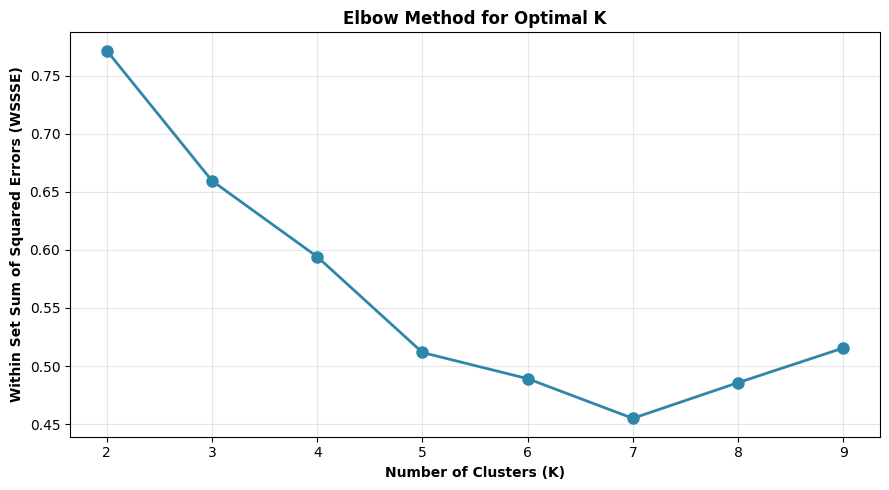

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 5))
plt.plot(range(2,10), silhouette_score, 'o-', color='#2E86AB', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (K)', fontweight='bold')
plt.ylabel('Within Set Sum of Squared Errors (WSSSE)', fontweight='bold')
plt.title('Elbow Method for Optimal K', fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(range(2,10))
plt.tight_layout()
plt.show()

- **¿Cúal k seleccionar?:**
  
Se debe seleccionar k = 3, porque en ese punto la curva empieza a “doblarse” de manera más radical, hasta ese punto, el valor del error disminuye bastante, pero después de k=3 la mejora es mínima.
Esto sugiere que 3 grupos son suficientes para representar bien los datos sin hacer el modelo más complejo.
- **¿Son satisfactorios los resultados de las diferentes k?:**

Sí, en general los resultados son satisfactorios.
La curva muestra que al aumentar el número de grupos (k), el puntaje mejora (disminuye la medida de error), pero la mejora se vuelve pequeña después de cierto punto. Esto significa que el algoritmo está encontrando una buena forma de agrupar los datos y que no es necesario usar un número muy alto de clusters.

- **Compare los resultados para k=4, k=6, k=8**
    - k = 4:
    Se observa una ligera mejora respecto a k=3, pero no tan significativa. Los grupos empiezan a dividirse demasiado y no se gana mucha precisión.

    - k = 6:
    La mejora es aún menor. Aunque los grupos se separan más, el puntaje indica que ya no hay una diferencia significativa; el modelo se vuelve más complejo sin una ganancia real en la calidad del agrupamiento.

    - k = 8:
    El resultado empeora un poco, lo que muestra que al aumentar demasiado los grupos,crea divisiones innecesarias entre datos que ya estaban bien agrupados.

### Entrenar el modelo

Se creará y entrenará el modelo K-Means definitivo usando k = 3, ya que se determinó que este es el número óptimo de grupos

In [12]:
kmeans = KMeans(k=3, featuresCol="scaledFeatures", predictionCol="cluster")
kmeans_model = kmeans.fit(df_datos)



### Evaluar el modelo k=3 Within Set Sum of Squared Errors (WSSSE) metric

Se aplica el modelo entrenado a los datos para ver a qué grupo pertenece cada registro.
Con "transform(df_datos)", el modelo analiza cada fila y le asigna un número de grupo.

Después, se calcula el valor del error, que mide qué tan bien formados están los grupos.
Este valor representa la suma de las distancias entre los puntos y el centro de su grupo:

In [13]:
output = KMeans_fit.transform(df_datos)
wssse = evaluador.evaluate(output)
print(f"Within Set Sum of Squared Errors (WSSSE) = {wssse}")

Within Set Sum of Squared Errors (WSSSE) = 0.5154780553895827


### Visualizar los Datos

**Descripción de la siguiente tabla**

La gráfica representa el resultado del algoritmo de K-means aplicado.
Su objetivo es evaluar cómo se agrupan los datos en función de sus características y visualizar la separación entre los diferentes clusters formados.

- Eje X: representa la variable sepal_length (longitud del sépalo).

- Eje Y: representa la variable sepal_width (ancho del sépalo).

- Colores: cada color corresponde a un cluster diferente, indicando a qué grupo fue asignado cada punto por el modelo.

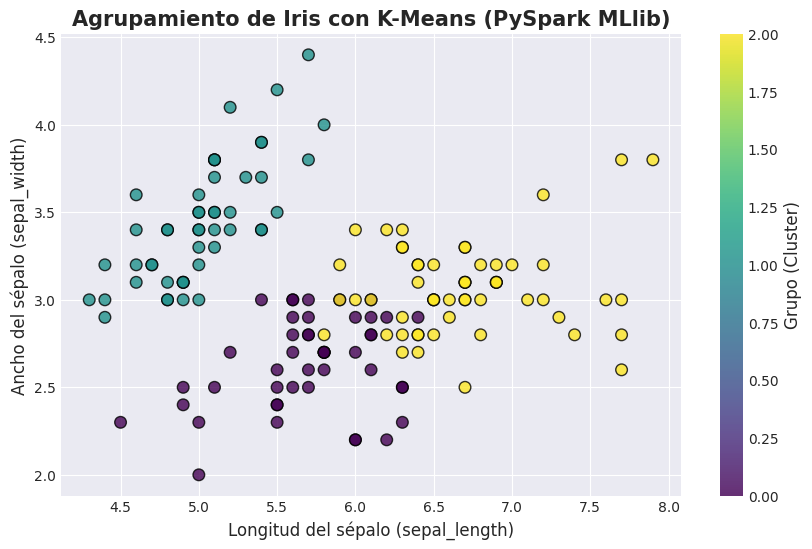

In [18]:
from pyspark.ml.clustering import KMeans
import matplotlib.pyplot as plt

# 1. Crear y entrenar el modelo K-Means
kmeans = KMeans(featuresCol="scaledFeatures", k=3, seed=42)
modelo_kmeans = kmeans.fit(df_datos)

# 2. Obtener las predicciones (datos clusterizados)
clustered_data = modelo_kmeans.transform(df_datos)

# 3. Convertir a Pandas DataFrame
clustered_data_pd = clustered_data.toPandas()

# 4. Visualizar los resultados
plt.style.use('seaborn-v0_8-darkgrid')
plt.figure(figsize=(10, 6))

# Dibujar los puntos
scatter = plt.scatter(
    clustered_data_pd["sepal_length"],
    clustered_data_pd["sepal_width"],
    c=clustered_data_pd["prediction"],
    cmap="viridis",
    s=70,            # tamaño de los puntos
    alpha=0.8,       # transparencia
    edgecolors='k'   # borde negro
)

# Personalización de la gráfica
plt.title("Agrupamiento de Iris con K-Means (PySpark MLlib)", fontsize=15, fontweight='bold')
plt.xlabel("Longitud del sépalo (sepal_length)", fontsize=12)
plt.ylabel("Ancho del sépalo (sepal_width)", fontsize=12)

# Barra de colores con etiqueta
cbar = plt.colorbar(scatter)
cbar.set_label("Grupo (Cluster)", fontsize=12)

# Mostrar gráfico
plt.show()


**Analisis grafica anterior:**

La gráfica muestra cómo el algoritmo K-Means agrupó las flores del conjunto Iris según la longitud y el ancho del sépalo. Cada color representa un grupo distinto, donde se observan tres zonas bien definidas que reflejan diferencias naturales entre las especies. Aunque hay una leve superposición entre algunos puntos, los clusters están claramente formados, mostrando que K-Means logra identificar patrones y separar los datos de forma efectiva.

Mostrar los nombres de todas las columnas

In [16]:
df_datos.columns

['sepal_length',
 'sepal_width',
 'petal_length',
 'petal_width',
 'Species',
 'features',
 'scaledFeatures']

**Descripción de la siguiente tabla**

Esta gráfica se utiliza para visualizar los resultados de K-Means, mostrando cómo se agrupan las flores del conjunto de datos Iris según las medidas de sus pétalos.

- Eje X: representa la longitud del pétalo (petal_length) medida en centímetros.

- Eje Y: representa el ancho del pétalo (petal_width) también en centímetros.

Cada punto en la gráfica representa una flor del conjunto de datos.
Los colores distintos indican a qué cluster (grupo) pertenece cada flor, según las similitudes entre sus medidas.

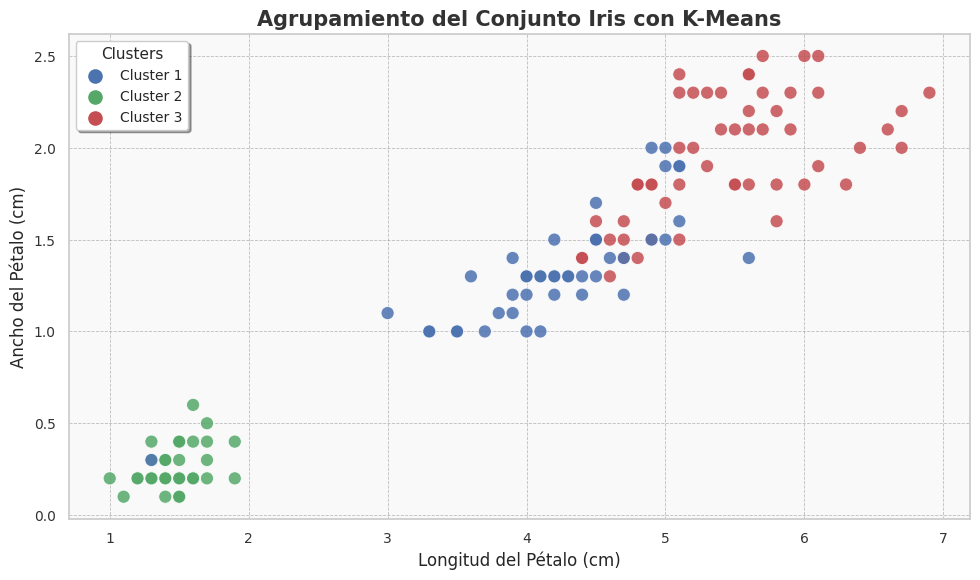

In [26]:
import numpy as np
import matplotlib.pyplot as plt

colors = ['#4C72B0', '#55A868', '#C44E52', '#8172B3', '#CCB974']

plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    x=clustered_data_pd["petal_length"],
    y=clustered_data_pd["petal_width"],
    c=[colors[i] for i in clustered_data_pd["prediction"]],
    s=90,                       # tamaño de los puntos
    alpha=0.85,                 # transparencia
    edgecolor='white',          # borde blanco
    linewidth=0.7
)

# Título y etiquetas
plt.title("Agrupamiento del Conjunto Iris con K-Means", fontsize=15, fontweight='bold', color='#333333')
plt.xlabel("Longitud del Pétalo (cm)", fontsize=12)
plt.ylabel("Ancho del Pétalo (cm)", fontsize=12)

# Leyenda de clusters
for i in range(3):
    plt.scatter([], [], color=colors[i], label=f'Cluster {i+1}', s=90)
plt.legend(title="Clusters", fontsize=10, title_fontsize=11, frameon=True, fancybox=True, shadow=True)

# Fondo, cuadrícula y estilo
plt.grid(True, which='both', color='gray', linestyle='--', linewidth=0.6, alpha=0.5)
plt.gca().set_facecolor("#F9F9F9")   # fondo gris claro
plt.tick_params(axis='both', which='major', labelsize=10, colors='#333333')
plt.tight_layout()
plt.show()


**Analisis grafica anterior:**

Esta gráfica muestra cómo el algoritmo K-Means agrupó los datos del conjunto Iris según la longitud y el ancho del pétalo. Cada color representa un grupo o cluster distinto, y se observa que los puntos verdes forman un grupo muy compacto y bien separado de los demás, mientras que los grupos azul y rojo están más cercanos, mostrando una ligera superposición. Esto indica que el tamaño del pétalo es una característica clave para diferenciar las especies, y que K-Means logra dividir de manera efectiva los datos en tres categorías naturales.

**Descripción de la siguiente tabla**

El propósito de esta grafica es visualizar si las longitudes y anchos de los sépalos permiten distinguir fácilmente entre las especies de flores.

- Eje X: representa la longitud del sépalo (sepal_length), medida en centímetros.

- Eje Y: representa el ancho del sépalo (sepal_width), también en centímetros.

Cada punto del gráfico es una observación (una flor), y los diferentes colores muestran los grupos formados por K-Means en función de estas dos variables.

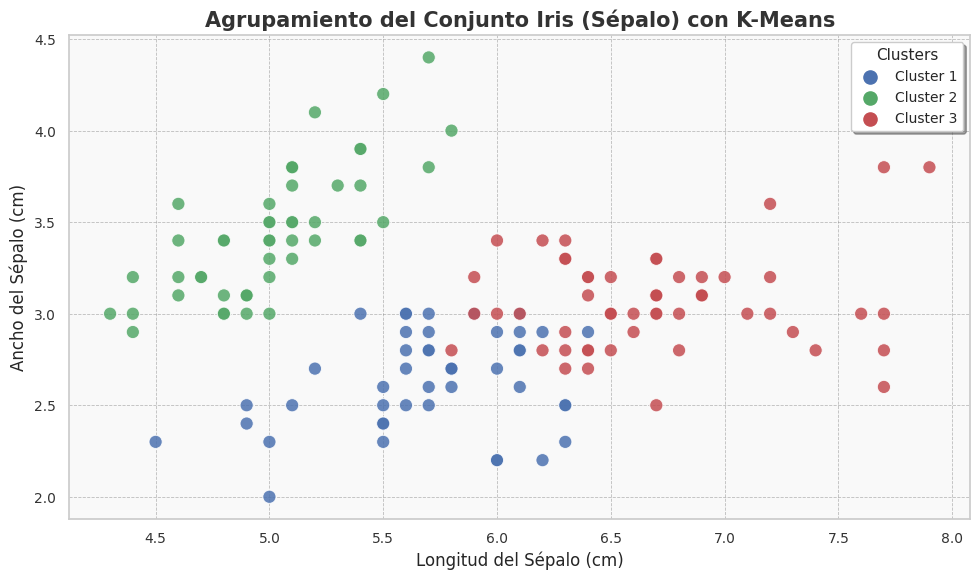

In [28]:
import numpy as np
import matplotlib.pyplot as plt

colors = ['#4C72B0', '#55A868', '#C44E52', '#8172B3', '#CCB974']

plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    x=clustered_data_pd["sepal_length"],
    y=clustered_data_pd["sepal_width"],
    c=[colors[i] for i in clustered_data_pd["prediction"]],
    s=90,                       # tamaño de los puntos
    alpha=0.85,                 # transparencia
    edgecolor='white',          # borde blanco
    linewidth=0.7
)

# Título y etiquetas
plt.title("Agrupamiento del Conjunto Iris (Sépalo) con K-Means", fontsize=15, fontweight='bold', color='#333333')
plt.xlabel("Longitud del Sépalo (cm)", fontsize=12)
plt.ylabel("Ancho del Sépalo (cm)", fontsize=12)

# Leyenda para los clusters
for i in range(3):
    plt.scatter([], [], color=colors[i], label=f'Cluster {i+1}', s=90)
plt.legend(title="Clusters", fontsize=10, title_fontsize=11, frameon=True, fancybox=True, shadow=True)

# Fondo, cuadrícula y estilo general
plt.grid(True, which='both', color='gray', linestyle='--', linewidth=0.6, alpha=0.5)
plt.gca().set_facecolor("#F9F9F9")   # fondo gris claro
plt.tick_params(axis='both', which='major', labelsize=10, colors='#333333')
plt.tight_layout()
plt.show()


**Analisis grafica anterior:**

Esta gráfica muestra cómo el algoritmo K-Means agrupó los datos del conjunto Iris utilizando la longitud y el ancho del sépalo. Cada color representa un grupo o cluster diferente. Se observa que el grupo verde está bien definido y separado, mientras que los grupos azul y rojo presentan cierta superposición. Esto indica que las medidas del sépalo no permiten distinguir las especies con tanta claridad como los pétalos, aunque K-Means sigue logrando una segmentación razonable al identificar patrones de similitud en los datos.

**Descripción de la siguiente tabla**

La gráfica muestra la distribución de los datos del conjunto Iris en función de las variables longitud del pétalo y ancho del pétalo, utilizando los resultados obtenidos de K-Means para identificar grupos naturales (clusters) dentro del conjunto.

 - Eje X: Representa el largo del pétalo de cada flor.
Valores mayores indican flores con pétalos más largos.

 - Eje Y: Indica el grosor o ancho del pétalo.

Cada color representa un cluster distinto, indicando a qué grupo pertenece cada flor según la similitud de sus características.

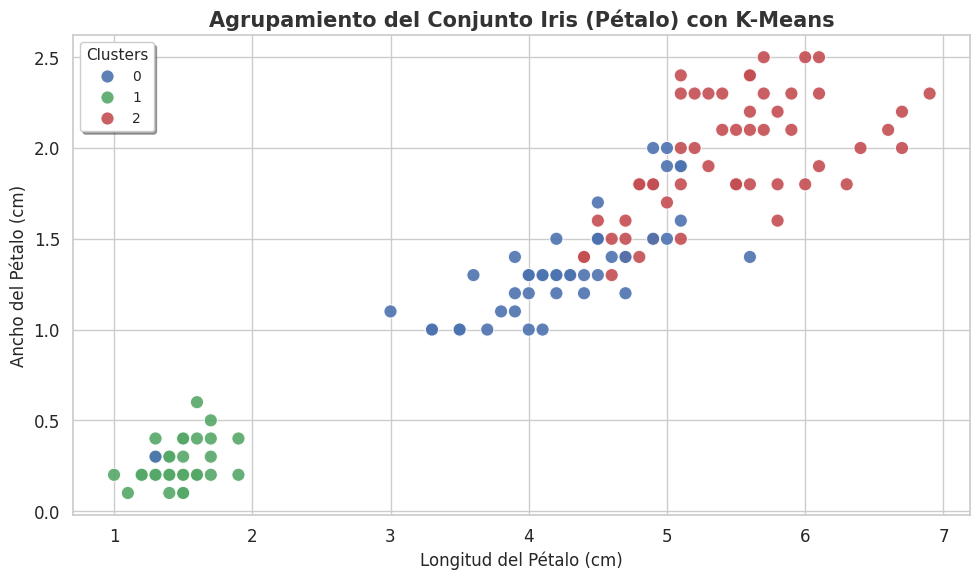

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid", palette="muted", font_scale=1.1)

# Crear la gráfica
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=clustered_data_pd,
    x='petal_length',
    y='petal_width',
    hue='prediction',
    palette=['#4C72B0', '#55A868', '#C44E52'],  # paleta elegante
    s=90,
    edgecolor='white',
    alpha=0.9
)

# Personalización del título y ejes
plt.title("Agrupamiento del Conjunto Iris (Pétalo) con K-Means", fontsize=15, fontweight='bold', color='#333333')
plt.xlabel("Longitud del Pétalo (cm)", fontsize=12)
plt.ylabel("Ancho del Pétalo (cm)", fontsize=12)
plt.legend(title="Clusters", title_fontsize=11, fontsize=10, frameon=True, fancybox=True, shadow=True)
plt.tight_layout()
plt.show()


**Analisis grafica anterior:**

Muestra el resultado del agrupamiento del conjunto de datos Iris mediante K-Means, utilizando las variables longitud y ancho del pétalo. En el plano cartesiano se observan tres grupos bien diferenciados, cada uno representado por un color distinto: el grupo verde (cluster 1) agrupa flores con pétalos cortos y estrechos, el azul (cluster 0) incluye flores con pétalos de longitud y ancho intermedios, y el rojo (cluster 2) corresponde a flores con pétalos largos y anchos. Este patrón evidencia una clara separación entre las especies, ya que las dimensiones del pétalo son características determinantes para su clasificación. Por lo que se logró identificar de manera efectiva las tres categorías naturales presentes en los datos del conjunto Iris.

In [25]:
spark.stop()

**Conclusion:**

A través de este trabajo se pudo entender cómo es posible agrupar datos sin contar con etiquetas utilizando K-Means. Al aplicarlo sobre el conjunto de datos de Iris, se lograron formar tres grupos bien diferenciados que reflejan con bastante precisión las especies de flores presentes. Utilizar K-Means resulta muy útil porque permite descubrir patrones y clasificar información de manera eficiente, incluso cuando no se conoce cómo están organizados los datos. Las gráficas generadas facilitaron la interpretación de los resultados y mostraron la coherencia de las agrupaciones. En conjunto, esta práctica demostró que K-Means es una herramienta sencilla pero poderosa para analizar datos y encontrar estructuras ocultas dentro de ellos.